In [2]:
include("../src/banerjee_overlapping.jl")
include("../src/BigClam.jl")
include("../src/attrAgmFit.jl")
include("../src/attrAgmFitMixture.jl")
include("../src/scores.jl")
include("../src/genAGM.jl")
include("../src/genAttrAGM.jl")
include("../src/utils.jl")
include("../src/conductanceComs.jl")
include("../src/attrAgmFitBinary.jl")
using .attrAgmFitBinary
using .BigClam
using .attrAgmFit
using .attrAgmFitMixture
using .genAGM
using .genAttrAGM
using .utils
using .conductanceComs

[ Info: Running `conda install -y -c anaconda conda` in root environment


Retrieving notices: done
Channels:
 - anaconda
 - defaults
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /home/lig02im-12/.julia/conda/3/x86_64

  added / updated specs:
    - conda


The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            conda-forge/noarch::certifi-2025.1.31~ --> anaconda/linux-64::certifi-2025.1.31-py312h06a4308_0 



Preparing transaction: | 



==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.1.1

Please update conda by running

    $ conda update -n base -c anaconda conda




done
Verifying transaction: done
Executing transaction: done


[ Info: Running `conda install -y -c conda-forge 'libstdcxx-ng>=3.4,<13.0'` in root environment


Channels:
 - conda-forge
 - defaults
 - anaconda
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /home/lig02im-12/.julia/conda/3/x86_64

  added / updated specs:
    - libstdcxx-ng[version='>=3.4,<13.0']


The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            anaconda/linux-64::certifi-2025.1.31-~ --> conda-forge/noarch::certifi-2025.1.31-pyhd8ed1ab_0 



Preparing transaction: - 



==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.1.1

Please update conda by running

    $ conda update -n base -c anaconda conda




done
Verifying transaction: done
Executing transaction: done


LoadError: LoadError: UndefVarError: `AttrAgmFit` not defined in `Main.attrAgmFitBinary`
Suggestion: check for spelling errors or missing imports.
in expression starting at /home/lig02im-12/FelipeSchreiber/LearningOnGraphs/attrAGM/src/attrAgmFitBinary.jl:3

In [3]:
using CSV
using DataFrames
using Distances
using Statistics
using NPZ
using PyPlot
using Graphs
using Random: bitrand
using BenchmarkTools
using Printf

In [4]:
Base.Libc.flush_cstdio()

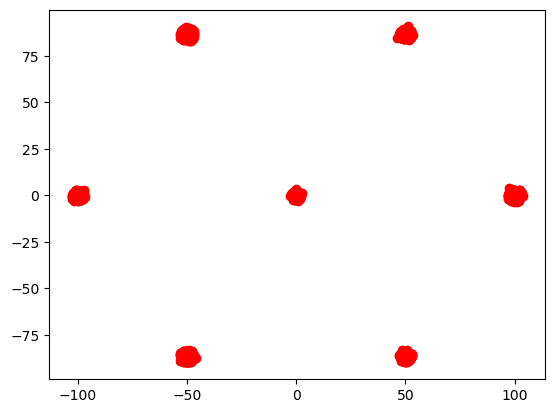

PyObject <matplotlib.collections.PathCollection object at 0x7f6a7a3894d0>

In [5]:
M = iszero.( npzread("membership_matrix.npy") )
Y = npzread("attr.npy")
scatter(Y[:,1],Y[:,2],color="red")

In [6]:
size(M),size(Y)

((14603, 3), (14603, 2))

In [7]:
arr = CSV.read("net.txt", DataFrame,delim=",",header=["u", "v", "w"])
using_exponential_weights = false
if (eltype(arr[!,:w]) == String)
    arr = DataFrames.transform(arr, [:w] => ByRow( w ->  parse.(Float64, split(chop(w; head=1, tail=1),)) )  => :W)
    println("Ok")
    using_exponential_weights = false
else
    using_exponential_weights = true
    println("Not ok")
end

Not ok


In [8]:
N,C = size(M)
K = C
# C+=1
F_init = rand(N, C)

14603×3 Matrix{Float64}:
 0.0424136  0.494157   0.462186
 0.202721   0.563672   0.205356
 0.316985   0.0975655  0.961873
 0.201061   0.091379   0.0578059
 0.341322   0.964138   0.515806
 0.777911   0.690561   0.774081
 0.492491   0.217638   0.588833
 0.758924   0.426384   0.325311
 0.909439   0.350067   0.0400972
 0.80212    0.86747    0.27476
 0.387629   0.304741   0.00823545
 0.198676   0.295777   0.598877
 0.0899844  0.436086   0.228514
 ⋮                     
 0.962001   0.334838   0.0513425
 0.714999   0.470741   0.858344
 0.24345    0.800545   0.315512
 0.442396   0.487371   0.82808
 0.0351759  0.569871   0.00838216
 0.888957   0.557751   0.443807
 0.481062   0.843599   0.383319
 0.142665   0.766542   0.447499
 0.316065   0.764152   0.419032
 0.80251    0.955646   0.12316
 0.150619   0.65164    0.410311
 0.935499   0.746085   0.824237

In [ ]:
#F = BigClam_fit(arr,3)
vertices_set = union!( Set(arr[:,"u"]), Set(arr[:,"v"]) )
N = length(vertices_set)
G = SimpleGraph{Int64}(N)
for row in eachrow(arr)
    add_edge!(G,row.u,row.v)
end
F = BigClam.fit(G, C, 100, 0.005, true, F_init, true, 0.001)
eps=10^-8
Thres = sqrt(-log(1-eps))

# n_edges = ne(G)
# n_vertices = nv(G)
# Thres = 2*n_edges/( n_vertices * (n_vertices - 1) )

F_bin = F.>Thres
avg_score(M,F_bin,f1_score),avg_score(M,F_bin,normalized_mutual_info_score),avg_score(M,F_bin,adjusted_rand_score)

In [ ]:
eltype(arr.W[1]),eltype(arr.w[1])

In [ ]:
G

In [ ]:
d = Dict{Tuple{Int64,Int64},Vector{Float64}}()
## assuming undirected graph
u = 0 
v = 0
for row in eachrow(arr)
    if row.u > row.v
        u, v = row.v, row.u
    else
        u, v = row.u, row.v
    end
    if using_exponential_weights
        d[(u,v)] = [row.w]
        d[(v,u)] = [row.w]
    else
        d[(u,v)] = row.W
    end
end

In [ ]:
N = 300
K = 3
D = 4   
p = 0.3
CmtyVV = utils.generate_bipartite_graph(N,K,nothing,p,nothing) #G(n,m,p)

params = genAttrAGM.AttrAgmParams()
params.agm_CProbV = [0.03,0.03,0.03]
params.agm_PNoCom = -1
params.agm_use_MCMC = true
params.agm_n_iter_MCMC = 1000
params.gen_edge_data_from_exp = true
params.weight_centers = rand(2*K,D)
params.n_clusters = K
println("Starting AGM")
n_cmty = size(CmtyVV)[1]
lambdas = collect(range(1,100,length=n_cmty+1))
params.lambdas = lambdas
G,d,Y,M = genAttrAGM.genAttrAgm(CmtyVV,params)
F_init = rand(N, K)

In [ ]:
cm = conductanceComs.CommunityMembership(nv(G),100)
conductanceComs.initialize_communities(G,cm,100)

In [ ]:
cm.F

In [13]:
d

Dict{Tuple{Int64, Int64}, Vector{Float64}} with 1460 entries:
  (111, 2)   => [0.00899907]
  (225, 291) => [0.182562]
  (98, 184)  => [0.120029]
  (83, 138)  => [0.0789018]
  (170, 158) => [0.0201857]
  (260, 143) => [0.478138]
  (265, 35)  => [0.00433547]
  (16, 99)   => [0.699159]
  (105, 266) => [0.0779001]
  (16, 201)  => [0.129161]
  (180, 202) => [0.00488896]
  (223, 183) => [0.0135426]
  (216, 208) => [0.00145343]
  (196, 98)  => [1.28052]
  (198, 224) => [0.00932079]
  (192, 299) => [0.0161354]
  (171, 71)  => [0.0276291]
  (70, 4)    => [0.0666987]
  (260, 51)  => [0.053342]
  (154, 187) => [0.0957991]
  (119, 197) => [0.248339]
  (56, 245)  => [0.49391]
  (8, 141)   => [0.00443334]
  (193, 281) => [0.00359927]
  (207, 259) => [0.153687]
  ⋮          => ⋮

In [14]:
G

{300, 730} undirected simple Int64 graph

Elapsed time: 00h:00m:0.04s


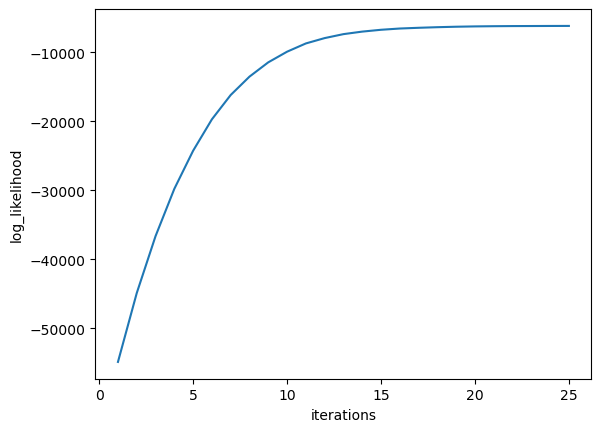

(0.6499792093317273, 0.1342634839645751, 0.17358685622253733)

In [15]:
start = time()
F = BigClam.fit(G, K, 100, 0.005, true, F_init, false, 0.001)
elapsed = time() - start
(minutes, seconds) = fldmod(elapsed, 60)
(hours, minutes) = fldmod(minutes, 60)
@printf("Elapsed time: %02dh:%02dm:%0.2fs\n", hours, minutes, seconds)

n_edges = ne(G)
n_vertices = nv(G)
Thres = 2*n_edges/( n_vertices * (n_vertices - 1) )

F_bin = F.>Thres
avg_score(M,F_bin,f1_score),avg_score(M,F_bin,normalized_mutual_info_score),avg_score(M,F_bin,adjusted_rand_score)

In [16]:
# F_init = F

USING 1 thread(s)
Elapsed time: 00h:00m:10.56s


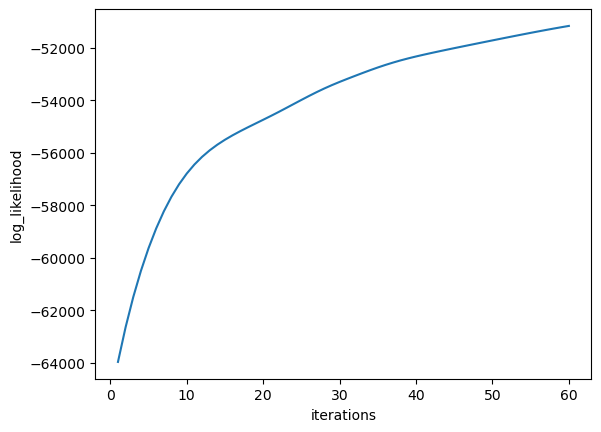

(0.7215056682561113, 0.23417083614051082, 0.28048010110522603)

In [17]:
"""
PYTHON TAKES 19.3 s ± 374 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
JULIA TAKES  4.388 s ± 332.737 ms (7 samples with 4 evaluations)
@benchmark F,A,B = fit_MLE(G,Y,d,3,100,model) evals=4 samples=7 seconds=600
"""

model = attrAgmFit.AttrAgmFit()
model.MaxVal = 100
model.update_F_use_line_search = false
model.update_F_use_riemmanian_grad = true
model.display_ll = true

start = time()

F,A,B = attrAgmFit.fit_MLE(G,Y,d,K,100,model,F_init,0.001)

elapsed = time() - start
(minutes, seconds) = fldmod(elapsed, 60)
(hours, minutes) = fldmod(minutes, 60)
@printf("Elapsed time: %02dh:%02dm:%0.2fs\n", hours, minutes, seconds)

eps=10^-8
Thres = sqrt(-log(1-eps))
    
# n_edges = ne(G)
# n_vertices = nv(G)
# Thres = 2*n_edges/( n_vertices * (n_vertices - 1) )


# Thres = 0.1
F_bin = F.>Thres
avg_score(M,F_bin,f1_score),avg_score(M,F_bin,normalized_mutual_info_score),avg_score(M,F_bin,adjusted_rand_score)

In [18]:
n_edges = ne(G)
n_vertices = nv(G)
Thres = 2*n_edges/( n_vertices * (n_vertices - 1) )

F_bin = F.>Thres
avg_score(M,F_bin,f1_score),avg_score(M,F_bin,normalized_mutual_info_score),avg_score(M,F_bin,adjusted_rand_score)

(0.7050651062496667, 0.21525980851041185, 0.27026806141549925)

In [19]:
Thres = median(F)
F_bin = F.>Thres
avg_score(M,F_bin,f1_score),avg_score(M,F_bin,normalized_mutual_info_score),avg_score(M,F_bin,adjusted_rand_score)

(0.7119740033834253, 0.2272311013132386, 0.2790739518058689)

USING 1 thread(s)

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Elapsed time: 00h:00m:5.28s


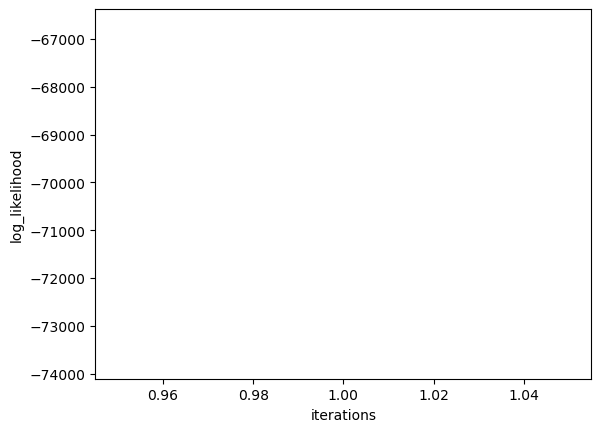

(0.6090468173541659, 0.004154036877595967, 0.00045748324836219605)

In [20]:
"""
PYTHON TAKES 19.3 s ± 374 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
JULIA TAKES  4.388 s ± 332.737 ms (7 samples with 4 evaluations)
@benchmark F,A,B = fit_MLE(G,Y,d,3,100,model) evals=4 samples=7 seconds=600
"""

model = attrAgmFitMixture.AttrAgmFit()
model.MaxVal = 100
model.update_F_use_line_search = false
model.update_F_use_riemmanian_grad = true
model.display_ll = true

start = time()

F,A,B = attrAgmFitMixture.fit_MLE(G,Y,d,K,100,model,nothing,0.001)

elapsed = time() - start
(minutes, seconds) = fldmod(elapsed, 60)
(hours, minutes) = fldmod(minutes, 60)
@printf("Elapsed time: %02dh:%02dm:%0.2fs\n", hours, minutes, seconds)

eps=10^-8
Thres = sqrt(-log(1-eps))
    
# n_edges = ne(G)
# n_vertices = nv(G)
# Thres = 2*n_edges/( n_vertices * (n_vertices - 1) )


# Thres = 0.1
F_bin = F.>Thres
avg_score(M,F_bin,f1_score),avg_score(M,F_bin,normalized_mutual_info_score),avg_score(M,F_bin,adjusted_rand_score)

In [21]:
n_edges = ne(G)
n_vertices = nv(G)
Thres = 2*n_edges/( n_vertices * (n_vertices - 1) )

F_bin = F.>Thres
avg_score(M,F_bin,f1_score),avg_score(M,F_bin,normalized_mutual_info_score),avg_score(M,F_bin,adjusted_rand_score)

(0.6075162296593357, 0.004367663115046551, 0.002707740059414504)

In [22]:
Thres = median(F)
F_bin = F.>Thres
avg_score(M,F_bin,f1_score),avg_score(M,F_bin,normalized_mutual_info_score),avg_score(M,F_bin,adjusted_rand_score)

(0.48922145016697954, 0.0030795115680078786, 0.0014616664344853968)

In [23]:
F[1:5,:]

5×3 Matrix{Float64}:
 0.942286  0.533384  0.972871
 0.879389  0.077099  0.415316
 0.528293  0.941243  0.14565
 0.160487  0.625288  0.694261
 0.824504  0.245627  0.695476

In [24]:
B

3-element Vector{Float64}:
  1.007233669851475
 71.44327989185265
 27.642028918629606

USING 1 thread(s)
Elapsed time: 00h:00m:0.43s


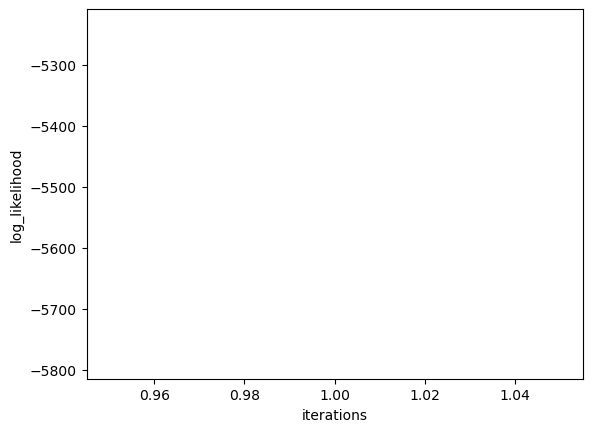

(0.6091157940491472, 0.0, 0.0)

In [25]:
"""
Traditional grad descent:
 3.013 s ± 214.434 ms (7 samples with 4 evaluations)
@benchmark F,A,B = fit_MLE(G,Y,d,3,100,model) evals=4 samples=7 seconds=600
"""

model.update_F_use_line_search = false
model.update_F_use_riemmanian_grad = false
model.display_ll = true

start = time()

F,A,B = attrAgmFitMixture.fit_MLE(G,Y,d,K,100,model,F_init,0.001)

elapsed = time() - start
(minutes, seconds) = fldmod(elapsed, 60)
(hours, minutes) = fldmod(minutes, 60)
@printf("Elapsed time: %02dh:%02dm:%0.2fs\n", hours, minutes, seconds)

eps=10^-8
Thres = sqrt(-log(1-eps))
    
# n_edges = ne(G)
# n_vertices = nv(G)
# Thres = 2*n_edges/( n_vertices * (n_vertices - 1) )

F_bin = F.>Thres
avg_score(M,F_bin,f1_score),avg_score(M,F_bin,normalized_mutual_info_score),avg_score(M,F_bin,adjusted_rand_score)

In [26]:
n_edges = ne(G)
n_vertices = nv(G)
Thres = 2*n_edges/( n_vertices * (n_vertices - 1) )

F_bin = F.>Thres
avg_score(M,F_bin,f1_score),avg_score(M,F_bin,normalized_mutual_info_score),avg_score(M,F_bin,adjusted_rand_score)

(0.6499792093317273, 0.1342634839645751, 0.17358685622253733)

In [27]:
Thres = median(F)
F_bin = F.>Thres
avg_score(M,F_bin,f1_score),avg_score(M,F_bin,normalized_mutual_info_score),avg_score(M,F_bin,adjusted_rand_score)

(0.6542895824760726, 0.13771475518842136, 0.17697048050291575)

In [28]:
F

300×3 Matrix{Float64}:
 0.053968   0.0840525  0.001
 0.001      0.001      0.221485
 0.001      0.267522   0.001
 0.001      0.001      0.21981
 0.001      0.177681   0.001
 0.249109   0.001      0.001
 0.001      0.315079   0.001
 0.001      0.404113   0.13541
 0.147581   0.001      0.001
 0.0437043  0.001      0.001
 0.001      0.001      0.131429
 0.0757362  0.0639905  0.001
 0.117496   0.202151   0.001
 ⋮                     
 0.001      0.001      0.0768061
 0.001      0.001      0.0863334
 0.19828    0.001      0.001
 0.001      0.0866691  0.001
 0.0963818  0.001      0.001
 0.001      0.0874093  0.001
 0.001      0.001      0.173984
 0.0973494  0.001      0.001
 0.145231   0.001      0.001
 0.001      0.132457   0.001
 0.135109   0.0987575  0.001
 0.0970983  0.001      0.001

In [29]:
B

3-element Vector{Float64}:
  1.3065322994899962
  2.7155847250190432
 58.90366587490231

In [30]:
A

3×2 Matrix{Float64}:
  1.73292    1.40107
  0.943953   0.206556
 -2.55981   -2.42822

In [31]:
Thres

0.001

In [32]:
n_edges = ne(G)
n_vertices = nv(G)
2*n_edges/( n_vertices * (n_vertices - 1) )

0.016276477146042363

In [33]:
CmtyVV = utils.generate_bipartite_graph(1000000,3,nothing,0.15)

3-element Vector{Vector{Int64}}:
 [4, 6, 11, 14, 16, 20, 21, 22, 34, 36  …  999950, 999958, 999961, 999974, 999975, 999976, 999981, 999982, 999988, 999993]
 [10, 13, 17, 21, 23, 38, 49, 54, 57, 58  …  999962, 999966, 999968, 999971, 999972, 999979, 999990, 999995, 999997, 999998]
 [6, 24, 35, 42, 43, 44, 50, 51, 55, 58  …  999951, 999957, 999960, 999963, 999967, 999969, 999970, 999977, 999984, 999999]

In [ ]:
G = genAGM.genAgm(CmtyVV,[0.3,0.2,0.1],-1.,false,10000)

In [35]:
### TO DO: Evaluate model

In [36]:
str_classification = classification_report(F_bin[:,1],M[:,1])
println(str_classification)

              precision    recall  f1-score   support

       False       0.73      0.76      0.74       164
        True       0.70      0.65      0.67       136

    accuracy                           0.71       300
   macro avg       0.71      0.71      0.71       300
weighted avg       0.71      0.71      0.71       300



In [37]:
res = f1_score(M[:,1],M[:,1])
eltype(res)

InterruptException: InterruptException:

In [38]:
N = length(vertices(G))
bitrand(N,3)

300×3 BitMatrix:
 0  1  1
 0  1  1
 0  1  1
 1  0  1
 0  0  1
 0  1  1
 0  0  1
 1  1  1
 0  0  1
 0  1  0
 1  0  0
 0  1  0
 0  1  1
 ⋮     
 0  1  1
 1  1  0
 0  1  0
 0  0  1
 0  0  1
 1  0  1
 0  0  1
 1  0  1
 0  0  0
 0  0  0
 1  1  1
 1  1  0

In [39]:
mean(F,dims=1)

1×3 Matrix{Float64}:
 0.0697077  0.077157  0.0780508

In [40]:
X = rand(100,5)
M = rand(100,3)
A = rand(3,5)
mean(M,dims=1),size(X),size(M),size(A)

([0.5230856128078188 0.5301438242036912 0.4855833313645009], (100, 5), (100, 3), (3, 5))

In [41]:
(X[1,:]' - (M[1,:]' * A))

1×5 adjoint(::Vector{Float64}) with eltype Float64:
 -0.400884  -0.0157764  -0.555931  0.179094  0.433377

In [42]:
size(M[1,:]' * A)

(1, 5)

In [43]:
sum( sqrt(sum( (X[i, :]' -  (M[i, :]' * A) ).^2)) for i in 1:100)

129.2980444103901

In [54]:
function euclidean_distance(p1, p2)
    if length(p1) != length(p2)
        throw(DimensionMismatch("Vectors must have the same length"))
    end
    return sum((p1 .- p2).^2)
end

euclidean_distance (generic function with 1 method)

In [55]:
N,D = size(Y)
b = BanerjeeOverlapping(3,euclidean_distance,N,D)

BanerjeeOverlapping(3, Main.euclidean_distance, 300, 2)

In [56]:
typeof(euclidean)

Euclidean

In [57]:
b.dist_func( rand(3)[1] , rand(3)[1] )

0.10657738074224453

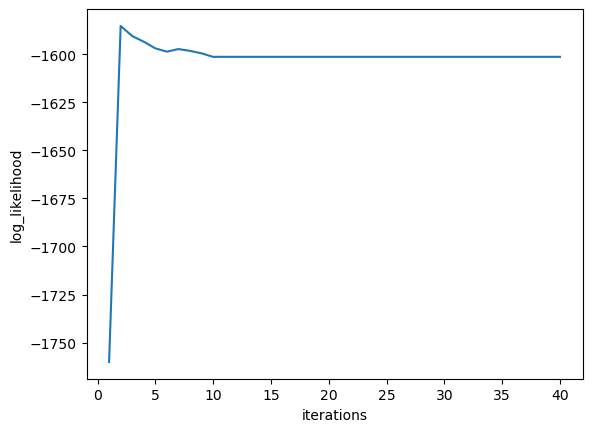

(Bool[0 1 1; 0 0 0; … ; 1 1 0; 0 1 1], [0.5697323698840676 0.46026879696325995; -1.4821305639552784 -1.3786662078083072; 0.9191907698862778 1.0813353234414254], [0.3833333333333333 0.61 0.5466666666666666; 0.3833333333333333 0.39 0.45333333333333337; … ; 0.6166666666666667 0.61 0.45333333333333337; 0.3833333333333333 0.61 0.5466666666666666])

In [66]:
M_pred,A,alphas = fit(b, Y, 3, 40, true)
# scatter(A[:,1],A[:,2],color="red")
# scatter(Y[:,1],Y[:,2],color="blue")

In [70]:
eltype(M_pred) == Bool

true

In [67]:
compute_all_metrics(M,M_pred)

3-element Vector{Float64}:
 0.7263886919964146
 0.17972986203141395
 0.21996426829759155

In [50]:
A

3×2 Matrix{Float64}:
  1.72065    1.57967
 -1.20025   -1.14753
 -0.687827  -0.589739

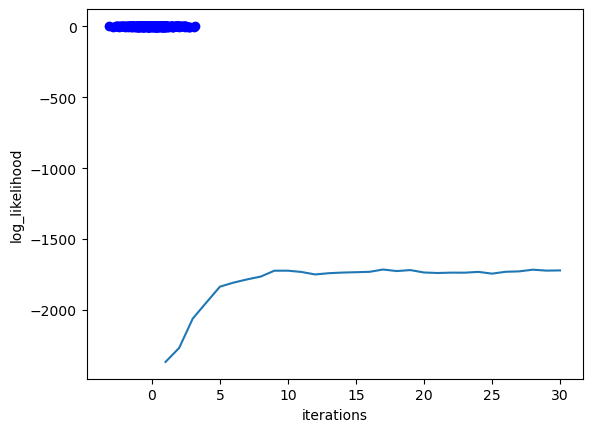

PyObject <matplotlib.collections.PathCollection object at 0x7f5f255dac50>

In [64]:
M,A,alphas = fit(b, Y, 3, 30, false)
scatter(A[:,1],A[:,2],color="red")
scatter(Y[:,1],Y[:,2],color="blue")

In [65]:
A

3×2 Matrix{Float64}:
  0.682382   0.773632
 -1.18321   -1.21936
  0.512807   0.660275

In [ ]:
M,A,alphas = fit_relaxed(b, Y, 3, 10)
scatter(A[:,1],A[:,2],color="red")
scatter(Y[:,1],Y[:,2],color="blue")

In [ ]:
A

In [ ]:
M,A,alphas = fit_joint(b, Y, 3)
scatter(A[:,1],A[:,2],color="red")
scatter(Y[:,1],Y[:,2],color="blue")

In [ ]:
M,A,alphas = fit_joint_relaxed(b, Y, 3)
scatter(A[:,1],A[:,2],color="red")
scatter(Y[:,1],Y[:,2],color="blue")

In [ ]:
M[1:5,:]

In [ ]:
A

In [ ]:
alphas